In [44]:
from flask import Flask, request, jsonify
from ultralytics import YOLO
from PIL import Image, ImageDraw
import io
from IPython.display import display

# Инициализация Flask и модели YOLO
app = Flask(__name__)
model = YOLO('yolov8m.pt')  # Используем "n" (nano), чтобы ускорить обработку

@app.route('/detect', methods=['POST'])
def detect():
    # Получение изображения из POST-запроса
    if 'file' in request.files:
        img = Image.open(request.files['file'])
    else:
        img_bytes = request.get_data()
        img = Image.open(io.BytesIO(img_bytes))

    # Выполняем детекцию
    results = model(img)

    # Визуализация результатов
    draw = ImageDraw.Draw(img)
    for box in results[0].boxes:
        cls = int(box.cls[0])  # Класс объекта
        conf = float(box.conf[0])  # Уверенность детекции
        x1, y1, x2, y2 = map(float, box.xyxy[0])  # Координаты (xmin, ymin, xmax, ymax)
        label = f"{model.names[cls]} {conf:.2f}"
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw.text((x1, y1), label, fill="red")

    # Отображение изображения в Jupyter Notebook
    display(img)

    # Сохранение изображения в байтовый поток для ответа
    output = io.BytesIO()
    img.save(output, format="JPEG")
    output.seek(0)

    return (output.getvalue(), 200, {"Content-Type": "image/jpeg"})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.10:5000
Press CTRL+C to quit


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.102:5000
Press CTRL+C to quit



0: 640x640 2 cars, 1 truck, 1 dining table, 26.2ms
Speed: 3.9ms preprocess, 26.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


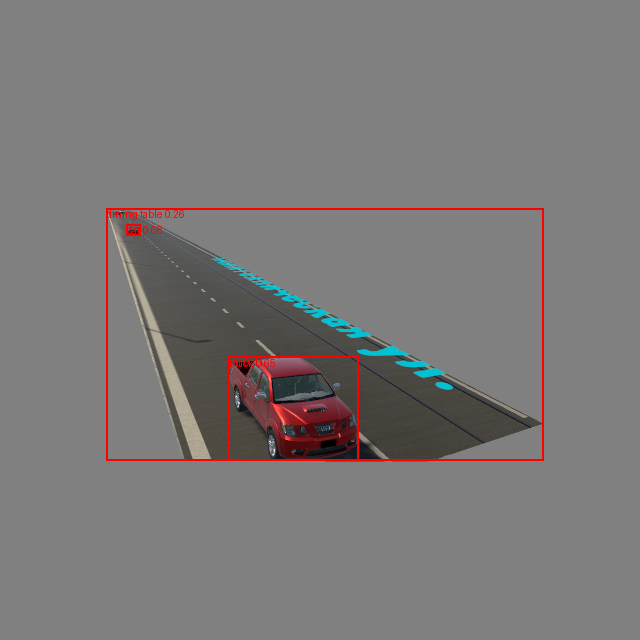

[2025-02-15 17:39:24,516] ERROR in app: Exception on /detect [POST]
Traceback (most recent call last):
  File "c:\Users\User\anaconda3\envs\py310_torch\lib\site-packages\PIL\JpegImagePlugin.py", line 639, in _save
    rawmode = RAWMODE[im.mode]
KeyError: 'RGBA'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\User\anaconda3\envs\py310_torch\lib\site-packages\flask\app.py", line 1511, in wsgi_app
    response = self.full_dispatch_request()
  File "c:\Users\User\anaconda3\envs\py310_torch\lib\site-packages\flask\app.py", line 919, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "c:\Users\User\anaconda3\envs\py310_torch\lib\site-packages\flask\app.py", line 917, in full_dispatch_request
    rv = self.dispatch_request()
  File "c:\Users\User\anaconda3\envs\py310_torch\lib\site-packages\flask\app.py", line 902, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(*

In [4]:
from flask import Flask, request, jsonify
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageOps
import io
from IPython.display import display

# Инициализация Flask и модели YOLO
app = Flask(__name__)
model = YOLO('yolov8m.pt')  # Используем "m" (medium) для баланса скорости и точности

# Словарь масок для разных камер
camera_masks = {
    "1": "camera6mask1.png"
    
}

def apply_mask(image, mask_path):
    """Применяет маску к изображению"""
    if not mask_path or not mask_path.endswith(('.png', '.jpg', '.jpeg')):
        return image

    try:
        mask = Image.open(mask_path).convert("L")  # Загружаем маску в оттенках серого
        mask = ImageOps.fit(mask, image.size, method=Image.Resampling.LANCZOS)
        masked_image = Image.composite(
            image, Image.new("RGB", image.size, (0, 0, 0)), mask
        )
        return masked_image
    except Exception as e:
        print(f"Ошибка применения маски: {e}")
        return image

@app.route('/detect', methods=['POST'])
def detect():
    # Получение изображения из POST-запроса
    if 'file' in request.files:
        img = Image.open(request.files['file'])
    else:
        img_bytes = request.get_data()
        img = Image.open(io.BytesIO(img_bytes))

    # Получение ID камеры
    camera_id = request.form.get('camera_id')
    mask_path = camera_masks.get(camera_id)

    # Применяем маску, если она указана
    if mask_path:
        img = apply_mask(img, mask_path)

    # Выполняем детекцию
    results = model(img)

    # Визуализация результатов
    draw = ImageDraw.Draw(img)
    for box in results[0].boxes:
        cls = int(box.cls[0])  # Класс объекта
        conf = float(box.conf[0])  # Уверенность детекции
        x1, y1, x2, y2 = map(float, box.xyxy[0])  # Координаты (xmin, ymin, xmax, ymax)
        label = f"{model.names[cls]} {conf:.2f}"
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw.text((x1, y1), label, fill="red")

    # Отображение изображения в Jupyter Notebook
    display(img)

    # Сохранение изображения в байтовый поток для ответа
    output = io.BytesIO()
    img.save(output, format="JPEG")
    output.seek(0)

    return (output.getvalue(), 200, {"Content-Type": "image/jpeg"})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)


In [ ]:
!pip install ultralytics pyzmq pillow

In [ ]:
import zmq
import io
import json
from PIL import Image
from ultralytics import YOLO

# Условная модель
model_path = "yolov8m.pt"
model = YOLO(model_path)
model.to("cuda")  # или .to("cpu")

print(f"Loaded model: {model_path}")

# Определим классы для person / transport
PERSON_CLASS_IDS = {0}
TRANSPORT_CLASS_IDS = {2, 3, 5, 6, 7}

def main():
    # Создаём сокет REP
    context = zmq.Context()
    rep_socket = context.socket(zmq.REP)
    rep_socket.bind("tcp://0.0.0.0:5555")  # слушаем порт 5555

    print("REQ/REP сервер запущен на tcp://0.0.0.0:5555")

    while True:
        try:
            # Читаем multi-part запрос: ждем 2 фрейма
            #  1) wanted_str (напр. "person" или "transport")
            #  2) байты картинки
            frames = rep_socket.recv_multipart()
            if len(frames) < 2:
                # Если меньше 2 фреймов, пропускаем
                rep_socket.send_string("ERROR: not enough frames")
                continue

            wanted_str = frames[0].decode('utf-8')
            image_bytes = frames[1]

            # Декодируем в PIL Image
            img = Image.open(io.BytesIO(image_bytes))

            # Выполняем детекцию
            results = model(img)

            # Определяем нужные class_ids
            if wanted_str == "person":
                wanted_ids = PERSON_CLASS_IDS
            elif wanted_str == "transport":
                wanted_ids = TRANSPORT_CLASS_IDS
            else:
                wanted_ids = None  # Если что-то иное - обрабатывайте по-своему

            count = 0
            if wanted_ids is not None:
                for box in results[0].boxes:
                    cls = int(box.cls[0])
                    conf = float(box.conf[0])
                    if cls in wanted_ids and conf >= 0.3:
                        count += 1

            # Формируем JSON ответ
            resp_json = json.dumps({"count": count})
            print(f"Requested: {wanted_str}, count={count}")

            # Отправляем ответ (одним фреймом)
            rep_socket.send_string(resp_json)

        except Exception as e:
            err_str = f"ERROR: {e}"
            print(err_str)
            # Пробуем отослать ошибку
            rep_socket.send_string(err_str)

if __name__ == "__main__":
    main()


0: 384x640 1 dining table, 146.5ms
Speed: 14.9ms preprocess, 146.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Requested: transport, count=0

0: 384x640 1 airplane, 16.8ms
Speed: 4.5ms preprocess, 16.8ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)
Requested: transport, count=0

0: 384x640 2 benchs, 1 surfboard, 16.2ms
Speed: 2.7ms preprocess, 16.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)
Requested: person, count=0

0: 384x640 1 airplane, 19.7ms
Speed: 3.7ms preprocess, 19.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Requested: transport, count=0

0: 384x640 1 bench, 17.9ms
Speed: 4.3ms preprocess, 17.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Requested: person, count=0

0: 384x640 (no detections), 16.7ms
Speed: 3.1ms preprocess, 16.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
Requested: person, count=0

0: 384x640 (no detections), 17.0ms
Speed

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8m.pt')

model.export(format='onnx', 
             opset=12)

дальше идут графики по анализу csv файла

In [2]:
import pandas as pd

df = pd.read_csv(r"C:\Users\User\Desktop\detections_28_03.csv", delimiter=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74592 entries, 0 to 74591
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CameraName         74592 non-null  object
 1   DetectType         74592 non-null  object
 2   TrafficLightState  74592 non-null  object
 3   Count              74592 non-null  int64 
 4   Timestamp          74592 non-null  object
 5   Duration           74592 non-null  object
dtypes: int64(1), object(5)
memory usage: 3.4+ MB


In [18]:
df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')

In [20]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

In [19]:
df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74592 entries, 0 to 74591
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CameraName         74592 non-null  object 
 1   DetectType         74592 non-null  object 
 2   TrafficLightState  74592 non-null  object 
 3   Count              74592 non-null  int64  
 4   Timestamp          74592 non-null  object 
 5   Duration           25021 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 3.4+ MB


In [21]:
df['CameraName'].value_counts()

CameraName
View10    12432
View7     12432
View11    12432
View5     12432
View8      6216
View9      6216
View12     6216
View6      6216
Name: count, dtype: int64

In [5]:
df['DetectType'].value_counts()

DetectType
person       49728
transport    24864
Name: count, dtype: int64

In [22]:
grouped_detect = df.groupby(['DetectType', 'TrafficLightState'])['Count'].sum().reset_index()
grouped_detect

,DetectType,TrafficLightState,Count
0,person,green,37972
1,person,red,16767
2,person,unknown,13632
3,person,yellow,6761
4,transport,green,59105
5,transport,red,22320
6,transport,unknown,18174
7,transport,yellow,8371


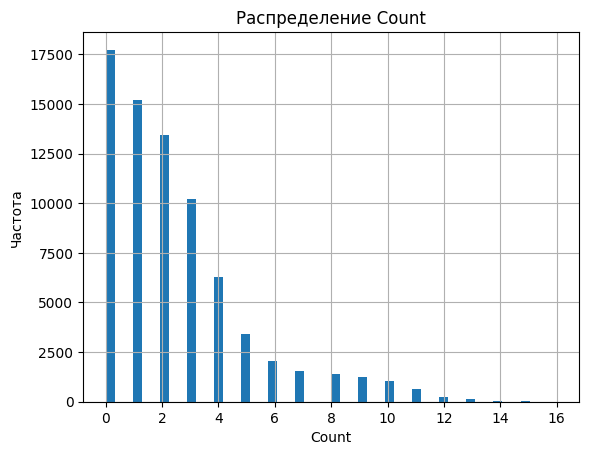

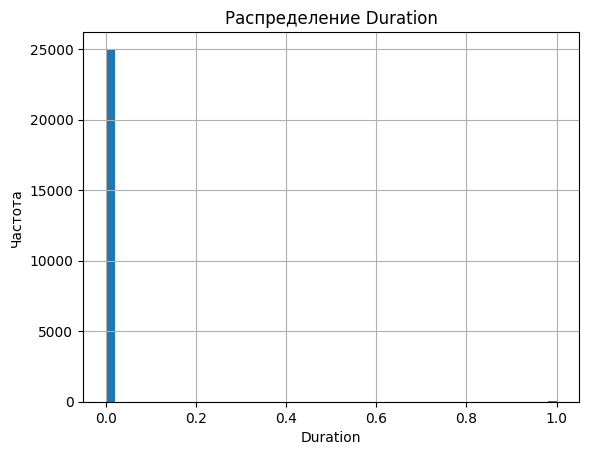

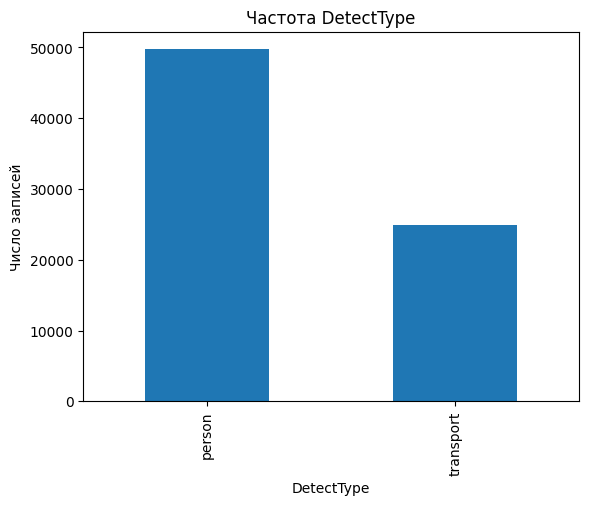

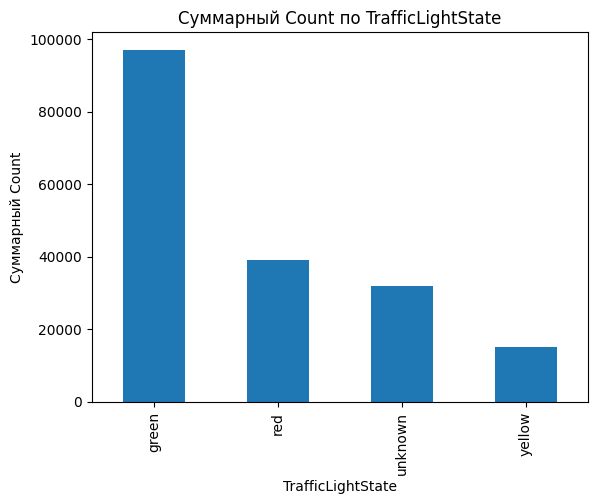

In [23]:
import matplotlib.pyplot as plt

plt.figure()
df['Count'].hist(bins=50)  # bins=50 – пример, можно менять
plt.title("Распределение Count")
plt.xlabel("Count")
plt.ylabel("Частота")

# 4.2 Распределение Duration (если успешно приведён к числу)
if pd.api.types.is_numeric_dtype(df['Duration']):
    plt.figure()
    df['Duration'].hist(bins=50)
    plt.title("Распределение Duration")
    plt.xlabel("Duration")
    plt.ylabel("Частота")

# 4.3 Распределение DetectType (гистограмма категорий)
plt.figure()
df['DetectType'].value_counts().plot(kind='bar')
plt.title("Частота DetectType")
plt.xlabel("DetectType")
plt.ylabel("Число записей")

# 4.4 Суммарный Count по TrafficLightState
plt.figure()
df.groupby('TrafficLightState')['Count'].sum().plot(kind='bar')
plt.title("Суммарный Count по TrafficLightState")
plt.xlabel("TrafficLightState")
plt.ylabel("Суммарный Count")

# 4.5 Если нужно посмотреть динамику во времени (и если Timestamp корректно преобразован в datetime):
# Сгруппируем данные по дате/часу и посмотрим, как меняется общий Count
if pd.api.types.is_datetime64_any_dtype(df['Timestamp']):
    # Пример: сгруппируем по дате (без учёта времени)
    df['Date'] = df['Timestamp'].dt.date
    daily_count = df.groupby('Date')['Count'].sum().reset_index()

    plt.figure()
    plt.plot(daily_count['Date'], daily_count['Count'])
    plt.title("Динамика Count по датам")
    plt.xlabel("Дата")
    plt.ylabel("Суммарный Count")
    plt.xticks(rotation=45)  # Поворот меток оси Х для наглядности

plt.show()

In [ ]:
plt.figure()
plt.plot(df['Timestamp'], df['Duration'])
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_18748\2205664468.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_car_resampled = df_car.resample('H').sum(numeric_only=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18748\2205664468.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_human_resampled = df_human.resample('H').sum(numeric_only=True)


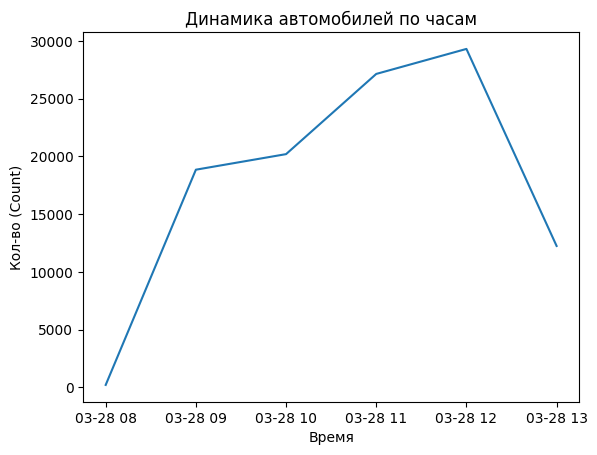

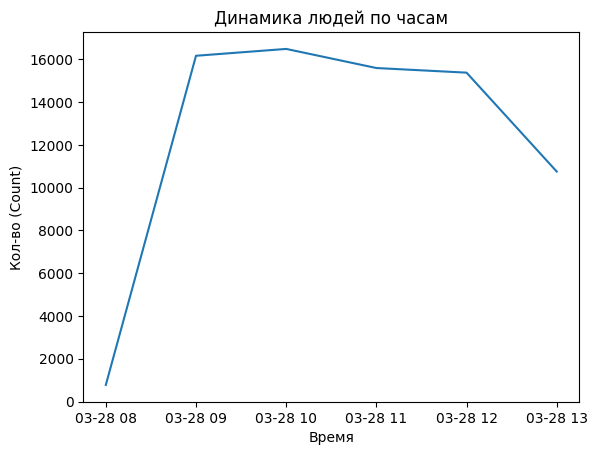

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Допустим, df уже загружен
# Убедимся, что Timestamp действительно datetime:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Фильтруем по типу
df_car = df[df['DetectType'] == 'transport'].copy()
df_human = df[df['DetectType'] == 'person'].copy()

# Ставим Timestamp в индекс, чтобы удобно делать ресемплинг
df_car.set_index('Timestamp', inplace=True)
df_human.set_index('Timestamp', inplace=True)

# Пример: группируем (ресемплим) по часу, суммируем Count
df_car_resampled = df_car.resample('H').sum(numeric_only=True)
df_human_resampled = df_human.resample('H').sum(numeric_only=True)

# Строим график для автомобилей
plt.figure()
plt.plot(df_car_resampled.index, df_car_resampled['Count'])
plt.title("Динамика автомобилей по часам")
plt.xlabel("Время")
plt.ylabel("Кол-во (Count)")

# Отображаем график
plt.show()

# Строим график для людей
plt.figure()
plt.plot(df_human_resampled.index, df_human_resampled['Count'])
plt.title("Динамика людей по часам")
plt.xlabel("Время")
plt.ylabel("Кол-во (Count)")

# Отображаем график
plt.show()


In [27]:
df5 = df[df['CameraName'] == 'View5'].sort_values('Timestamp')
df5['Duration'].max()

np.float64(1.0)

In [28]:
df['Duration'].mean()

np.float64(0.002397985692018704)

In [29]:
weighted_avg_duration = (df['Duration'] * df['Count']).sum() / df['Count'].sum()
print("Взвешенное среднее время ожидания:", weighted_avg_duration)

Взвешенное среднее время ожидания: 0.0007209096569125406


In [30]:
# среднее реальное время горения сигнала:
mean_phase = df.groupby(['Timestamp', 'TrafficLightState'])['Duration'].max().mean()
print("среднее время ожидания:", mean_phase)


среднее время ожидания: 0.002397985692018704


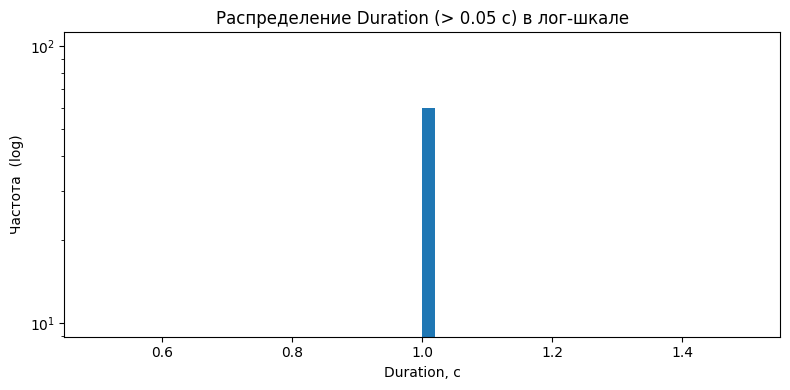

In [31]:
# ─────────────────── 2. подготовка Duration ───────────────────
# приводим к float через to_numeric (NaN, если не‑число)
df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')

# ─────────────────── 3. фильтрация ненулевых значений ───────────────────
dur = df.loc[df['Duration'] > 0.05, 'Duration']   # > 0.05 с

# ─────────────────── 4. построение гистограммы ───────────────────
plt.figure(figsize=(8, 4))
plt.hist(dur, bins=50)        # можно изменить bins
plt.yscale('log')             # логарифмическая шкала по Y
plt.title("Распределение Duration (> 0.05 с) в лог‑шкале")
plt.xlabel("Duration, с")
plt.ylabel("Частота  (log)")
plt.tight_layout()
plt.show()

Взвешенное среднее ожидание (реальные секунды): 0.0007


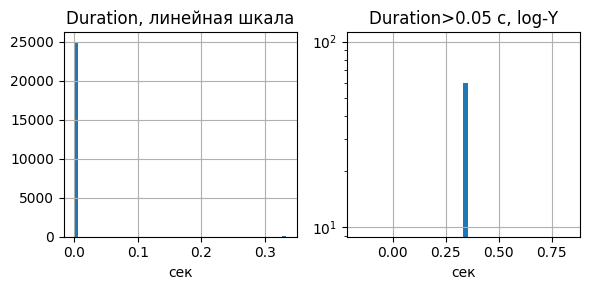

(-0.001333, 0.0333]    24961
(0.3, 0.333]              60
(0.0333, 0.0667]           0
(0.0667, 0.1]              0
(0.133, 0.167]             0
(0.1, 0.133]               0
(0.167, 0.2]               0
(0.2, 0.233]               0
(0.233, 0.267]             0
(0.267, 0.3]               0
Name: count, dtype: int64

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Читаем CSV

# 2) Приводим Duration и Count к числам
df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')
df['Count']    = pd.to_numeric(df['Count'],    errors='coerce')
df = df.dropna(subset=['Duration', 'Count'])

# 3) Конвертируем в реальные секунды
TIME_SCALE = 3             # как в Unity
df['Duration_real'] = df['Duration'] / TIME_SCALE   # делим, а не умножаем!

# 4) Фильтруем кадры без объектов, если хотим «ожидание на 1 объект»
nonzero = df['Count'] > 0

weighted = (df.loc[nonzero, 'Duration_real'] * df.loc[nonzero, 'Count']).sum() \
           / df.loc[nonzero, 'Count'].sum()
print(f"Взвешенное среднее ожидание (реальные секунды): {weighted:.4f}")

# 5) Показываем обе гистограммы
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); df['Duration_real'].hist(bins=50)
plt.title("Duration, линейная шкала"); plt.xlabel("сек")

plt.subplot(1,2,2); df[df['Duration_real']>0.05]['Duration_real'].hist(
        bins=50, log=True)        # логарифмическая Y после отсечения шума
plt.title("Duration>0.05 с, log‑Y"); plt.xlabel("сек")

plt.tight_layout(); plt.show()

df['Duration_real'].describe()
df['Duration_real'].value_counts(bins=10)

In [38]:
import pandas as pd

time_scale = 3                        # Unity Time.timeScale
frame_interval = 1                    # Вы отправляли 1 кадр / с

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values(['CameraName', 'Timestamp'])

# 1. сегмент = непрерывная серия кадров с одним цветом
df['seg_id'] = (df.groupby('CameraName')['TrafficLightState']
                  .apply(lambda s: (s != s.shift()).cumsum())
                  .reset_index(level=0, drop=True))

# 2. длительность и суммарное число объектов в каждой фазе
segments = (df.groupby(['CameraName', 'seg_id'])
              .agg(state    = ('TrafficLightState', 'first'),
                   start    = ('Timestamp', 'first'),
                   end      = ('Timestamp', 'last'),
                   frames   = ('Timestamp', 'size'),
                   total_cnt= ('Count', 'sum'))
           ).reset_index(drop=True)

segments['Duration_real'] = (segments['end']-segments['start']).dt.total_seconds() / time_scale


In [39]:
# проверка
print(segments['Duration_real'].value_counts().sort_index())


Duration_real
0.000000    8303
0.036000       1
0.036333       3
0.036667       6
0.037000       8
            ... 
1.274667       1
1.276000       1
1.289333       1
1.308000       1
1.418667       1
Name: count, Length: 680, dtype: int64


In [40]:
w_avg = (segments['total_cnt']*segments['Duration_real']).sum() / segments['total_cnt'].sum()
print("Взвешенное среднее ожидание (корректно):", w_avg)


Взвешенное среднее ожидание (корректно): 0.10463150264657295


In [41]:
df_pos = df[df['Duration_real'] > 1e-3]          # > 0.001 с
w_avg = (df_pos['Duration_real'] * df_pos['Count']).sum() / df_pos['Count'].sum()
print("⟨T⟩ без нулевых кадров:", w_avg)


⟨T⟩ без нулевых кадров: 0.33333333333333326


In [43]:
import pandas as pd
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values(['CameraName', 'Timestamp'])

#   id сегмента = накопленный счётчик смен цвета
df['seg'] = (df.groupby('CameraName')['TrafficLightState']
               .apply(lambda s: (s != s.shift()).cumsum())
               .reset_index(level=0, drop=True))

segments = (df.groupby(['CameraName', 'seg'])
              .agg(state=('TrafficLightState', 'first'),
                   start=('Timestamp', 'first'),
                   end=('Timestamp', 'last'),
                   objects=('Count', 'sum'))
            .reset_index(drop=True))

segments['Duration_real'] = (segments['end']-segments['start']).dt.total_seconds()/3
segments = segments[segments['Duration_real']>0]      # выкинем «мусорные» нули

w_avg = (segments['Duration_real']*segments['objects']).sum() / segments['objects'].sum()
print("⟨T⟩ по фазам:", w_avg)


⟨T⟩ по фазам: 0.2556088621669481
